In [15]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Images pre-processing => OK code Ready

In [16]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm

In [3]:
# Dict defining rotation and cropping depending on component
rot_crop_data = {
        "Die01":[55,(340, 120, 500, 680)], # (left, upper, right, lower)
        "Die02":[-44, (480, 210, 640, 930)],
        "Die03":[134, (460, 200, 620, 920)],
        "Die04":[35, (310, 130, 470, 690)]
}

In [4]:
train_pictures = '../input_train/input_train/'
train_csv = '../Y_train.csv'

In [61]:
from utils import rotate_and_crop_image

train_pictures = '../input_train/input_train/'
train_csv = '../Y_train.csv'
# test_csv = './win_and_lib.csv'

# Pre-process test data

def pre_process_rot_crop(data_pictures_path, data_labels_path, new_folder):

    if not os.path.exists(new_folder):
        os.makedirs(new_folder)

    if os.listdir(new_folder):  # If pre-processing already done, one must be careful not to run it again
        print('Pre-processing already done')
        return
    
    dataframe = pd.read_csv(data_labels_path)

    for index, row in tqdm(dataframe.iterrows()):
        path = os.path.join(data_pictures_path, row['filename'])
        rotate_and_crop_image(path, rot_crop_data[row['lib']][0], rot_crop_data[row['lib']][1], new_folder, plot=False)

new_folder = '../input_train_rotcrop/'
pre_process_rot_crop(train_pictures, train_csv, new_folder)

8278it [00:59, 138.28it/s]


In [35]:
# Filter the dataframe for 'Die01' images
dataframe = pd.read_csv(train_csv)

# Count the number of 'MISSING' and 'GOOD' labels for each 'Die'
label_counts = dataframe[dataframe['lib'].isin(['Die01', 'Die02', 'Die03', 'Die04'])].groupby(['lib', 'Label']).size().unstack(fill_value=0)
print(label_counts)

# Create a new folder to save cropped images
cropped_folder = '../input_train_new/'
if not os.path.exists(cropped_folder):
    os.makedirs(cropped_folder)

# Function to save cropped images
def save_cropped_images(dataframe, rotation_angle, crop_box, folder):
    for index, row in dataframe.iterrows():
        image_path = os.path.join(train_pictures, row['filename'])
        original_image = Image.open(image_path)
        cropped_image = original_image.rotate(rotation_angle, expand=True).crop(crop_box)
        cropped_image.save(os.path.join(folder, row['filename']))

# Process each Die
for die in ['Die01', 'Die02', 'Die03', 'Die04']:
    die_images = dataframe[dataframe['lib'] == die]
    rotation_angle, crop_box = rot_crop_data[die]
    
    # Filter and remove excess 'GOOD' images
    good_images = die_images[die_images['Label'] == 'GOOD']
    if len(good_images) > 100:
        good_images = good_images.sample(n=len(good_images) - 200)
    
    # Filter and remove excess 'Missing' images
    missing_images = die_images[die_images['Label'] == 'Missing']
    if len(missing_images) > 1000:
        missing_images = missing_images.sample(n=len(missing_images) - 1300)
    
    # Combine the filtered dataframes
    filtered_images = pd.concat([good_images, missing_images, die_images[~die_images['Label'].isin(['GOOD', 'Missing'])]])
    
    # Save cropped images
    save_cropped_images(filtered_images, rotation_angle, crop_box, cropped_folder)

    # Save the filtered dataframe to a new CSV file
    new_csv_path = f'../Y_train_new{die}.csv'
    filtered_images.to_csv(new_csv_path, index=False)

#  concatenate the new CSV files
new_csv_files = [f'../Y_train_new{die}.csv' for die in ['Die01', 'Die02', 'Die03', 'Die04']]
new_csv = pd.concat([pd.read_csv(file) for file in new_csv_files], ignore_index=True)
new_csv.to_csv('../Y_train_new.csv', index=False)

Label  Boucle plate  GOOD  Lift-off blanc  Lift-off noir  Missing  \
lib                                                                 
Die01            42   419               5              3     1715   
Die02             2   386              88             48     1670   
Die03             3    91              68             50     1607   
Die04            24   339             109              3     1480   

Label  Short circuit MOS  
lib                       
Die01                 52  
Die02                  7  
Die03                 25  
Die04                 42  


In [36]:
# Filter the dataframe for 'Die01' images
dataframe = pd.read_csv('../Y_train_new.csv')

# Count the number of 'MISSING' and 'GOOD' labels for each 'Die'
label_counts = dataframe[dataframe['lib'].isin(['Die01', 'Die02', 'Die03', 'Die04'])].groupby(['lib', 'Label']).size().unstack(fill_value=0)
print(label_counts)

count = 0
for _ in os.listdir('../input_train_new/'):
    count += 1
print(count)

Label  Boucle plate  GOOD  Lift-off blanc  Lift-off noir  Missing  \
lib                                                                 
Die01            42   219               5              3      415   
Die02             2   186              88             48      370   
Die03             3    91              68             50      307   
Die04            24   139             109              3      180   

Label  Short circuit MOS  
lib                       
Die01                 52  
Die02                  7  
Die03                 25  
Die04                 42  
2478


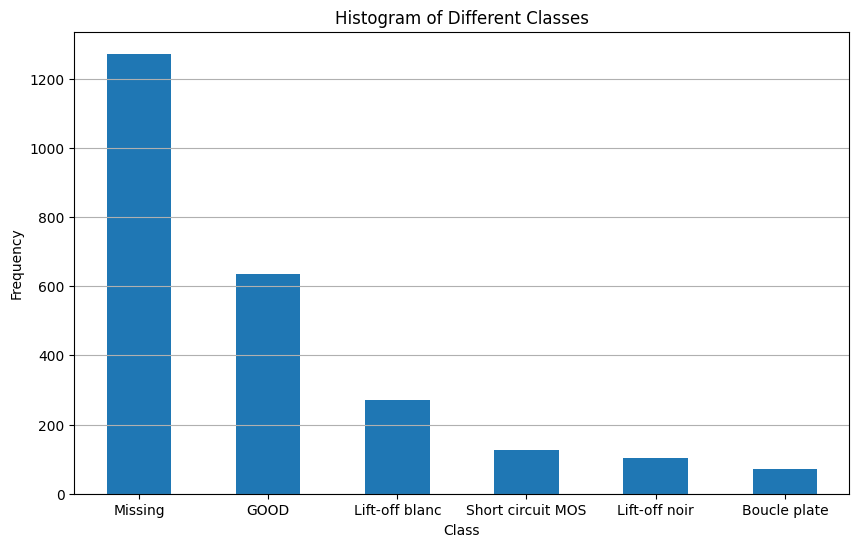

In [37]:
import matplotlib.pyplot as plt

# Plot histogram of different classes
plt.figure(figsize=(10, 6))
dataframe['Label'].value_counts().plot(kind='bar')
plt.title('Histogram of Different Classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

# Anomaly detection (PADIM) => OK

In [3]:
import random
from random import sample
import argparse
import numpy as np
import os
import pickle
from tqdm import tqdm
from collections import OrderedDict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import mahalanobis
from scipy.ndimage import gaussian_filter
from skimage import morphology
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.models import wide_resnet50_2, resnet18

import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [4]:
test_path = '../input_test_rotcrop/'
padim_trained = 'PADIM.pkl'
# train_path = 'input_train_rotcrop'

In [5]:
from utils import CustomDataset

# Charger les données d'entraînement
with open(padim_trained, 'rb') as f:
    train_outputs = pickle.load(f)

model = wide_resnet50_2(pretrained=True, progress=True)
t_d = 1792
d = 550


# device setup
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

model.to(device)
model.eval()
random.seed(1024)
torch.manual_seed(1024)
if use_cuda:
    torch.cuda.manual_seed_all(1024)

idx = torch.tensor(sample(range(0, t_d), d))

# set model's intermediate outputs
outputs = []

def hook(module, input, output):
    outputs.append(output)

model.layer1[-1].register_forward_hook(hook)
model.layer2[-1].register_forward_hook(hook)
model.layer3[-1].register_forward_hook(hook)


transform = transforms.Compose([
                                transforms.Resize((128, 128)),  # Redimensionner les images
                                transforms.ToTensor(),            # Convertir en tenseur
                                ])

test_dataset = CustomDataset(test_path, transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, pin_memory=True)
test_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', [])])

/home/emiliopicard/miniconda3/envs/valeo_env2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/emiliopicard/miniconda3/envs/valeo_env2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
        #####################
        #####################
        #####################
        #  FRAMEWORK PADIM  #
        #####################
        #####################
        #####################

test_imgs = []
filenames_list = []
scores_list = []

# extract test set features
for filename, x in tqdm(test_dataloader, '| feature extraction | test |'):
    filenames_list.extend(filename)  # Collect filenames for the batch
    test_imgs.extend(x.cpu().detach().numpy())
    # model prediction
    with torch.no_grad():
        _ = model(x.to(device))
    # get intermediate layer outputs
    for k, v in zip(test_outputs.keys(), outputs):
        test_outputs[k].append(v.cpu().detach())
    # initialize hook outputs
    outputs = []
for k, v in test_outputs.items():
    test_outputs[k] = torch.cat(v, 0)

| feature extraction | test |: 100%|██████████| 33/33 [00:05<00:00,  5.72it/s]


### DO NOT RUN

In [26]:
from utils import embedding_concat

# Embedding concat
embedding_vectors = test_outputs['layer1']
for layer_name in ['layer2', 'layer3']:
    embedding_vectors = embedding_concat(embedding_vectors, test_outputs[layer_name])

# randomly select d dimension
embedding_vectors = torch.index_select(embedding_vectors, 1, idx)

# calculate distance matrix
B, C, H, W = embedding_vectors.size()
embedding_vectors = embedding_vectors.view(B, C, H * W).numpy()
dist_list = []
for i in range(H * W):
    mean = train_outputs[0][:, i]
    conv_inv = np.linalg.inv(train_outputs[1][:, :, i])
    dist = [mahalanobis(sample[:, i], mean, conv_inv) for sample in embedding_vectors]
    dist_list.append(dist)

dist_list = np.array(dist_list).transpose(1, 0).reshape(B, H, W)

# upsample
dist_list = torch.tensor(dist_list)
score_map = F.interpolate(dist_list.unsqueeze(1), size=x.size(2), mode='bilinear',
                            align_corners=False).squeeze().numpy()

# apply gaussian smoothing on the score map
for i in range(score_map.shape[0]):
    score_map[i] = gaussian_filter(score_map[i], sigma=4)

# Normalization
max_score = score_map.max()
min_score = score_map.min()
scores = (score_map - min_score) / (max_score - min_score)

# calculate image-level ROC AUC score
img_scores = scores.reshape(scores.shape[0], -1).max(axis=1)

# Store scores and filenames
for filename, score in zip(filenames_list, img_scores):
    scores_list.append((filename, score))

: 

In [6]:
print(scores_list)

[('06c5f2fcc05710bdd24a660307f1f8aec53d38fe2258d97b36e7266e285e838f.png', 0.24338196), ('3233bb04a275664c0415cfd1ca84d721f6ee56e09595c8cc6ac0673b8711f3d0.png', 0.5059239), ('cb2ee07e3969eb12a3149395f0034f7c285d4aa6d9f6fb38fbc83ae9ab9a6499.png', 0.40772247), ('91eda638e6a3abe3b3c653af492177ffa2133b4f162262c196f1822c6a22ff8a.png', 0.15159838), ('67406bc029971e414e61363c6f0997a1477c73480f2ea32171b1c4b700007dc1.png', 0.16498451), ('b5e89885021e7e45129af5e2a43edd5938cf6160d1f3a603b888da5b75aa8d73.png', 0.21432307), ('3944ed158b9eea08cae20a150c5b947e8e5574b088d3a2ddcdaa362b771418ed.png', 0.31562677), ('f6351ae439a817d52bdaca00bd91a1698f027f28bec556846bcc03fe147da5cf.png', 0.15781191), ('e4cb8265a658bd78a533957ec2c402a2ebbeeeee64b27dec11ceb7f5465213cf.png', 0.2317898), ('13be8686440a9e8f62d42383c30758bf06b6e2ec4fedd61dfc92d43a94bfed7b.png', 0.37727642), ('fbc82e5e9e49f9c288071a617decbb7c36d67abcb823f4a3f9ea93b204169026.png', 0.22814181), ('214faf9942c9c6801df7bc5f0f5775a680645b9afc8f8d58aef24

In [7]:
y_pred_anomaly = scores_list

***
# **Classifier** - TRAINING:
***

In [11]:
import pickle

In [31]:
def load_list_from_file(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

y_pred_anomaly = load_list_from_file('scores_list.pkl')

In [6]:
from torchsummary import summary

classifier_file = './Classifier.pt'
model = torch.load(classifier_file, weights_only=False)

/home/emiliopicard/miniconda3/envs/valeo_env2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from utils import ImageDatasetTrain
import torch.nn as nn
from torchvision.models import resnet50, resnet101

class Finetuned_Resnet50(nn.Module):
    def __init__(self, num_classes=6):
        super(Finetuned_Resnet50, self).__init__()
        model = resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        self.resnet = model

        for param in self.resnet.parameters():
            param.requires_grad = False
        for param in self.resnet.fc.parameters():
            param.requires_grad = True

    def forward(self, x):
        output = self.resnet(x)
        return output


class Finetuned_Resnet101(nn.Module):
    def __init__(self, num_classes=6):
        super(Finetuned_Resnet101, self).__init__()
        model = resnet101(pretrained=True)
        model.fc = nn.Sequential(
            nn.Linear(model.fc.in_features, num_classes),
        )
        self.resnet = model

        for param in self.resnet.parameters():
            param.requires_grad = False

        for param in self.resnet.layer4.parameters():
            param.requires_grad = True  
        for param in self.resnet.fc.parameters():
            param.requires_grad = True

    def forward(self, x):
        output = self.resnet(x)
        return output

model = Finetuned_Resnet101()

/home/emiliopicard/miniconda3/envs/valeo_env2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/emiliopicard/miniconda3/envs/valeo_env2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [127]:
from utils import ImageDataset
import pandas as pd
from torch.utils.data import random_split
from torchsummary import summary


image_folder = '../input_train_new'


train_df = pd.read_csv('../Y_train_new.csv')
classes_dict = {
    "GOOD" : 0,
    "Boucle plate" : 1,
    "Lift-off blanc" : 2,
    "Lift-off noir" : 3,
    "Missing" : 4,
    "Short circuit MOS" : 5,
    "Drift" : 6
}
train_df['Label'] = train_df['Label'].replace(classes_dict)


# Transformation des images pour l'entrée du modèle
TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
])

DATASET = ImageDatasetTrain(image_folder, train_df, transform=TRANSFORM)
train_size = int(0.8 * len(DATASET))
val_size = len(DATASET) - train_size
TRAIN_DATASET, VAL_DATASET = random_split(DATASET, [train_size, val_size])

dataset_eval = ImageDataset(image_folder, transform=TRANSFORM)
_, val_dataset = random_split(dataset_eval, [train_size, val_size])
dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Chargement du dataset
BATCH_SIZE = 64

TRAIN_DATALOADER = DataLoader(TRAIN_DATASET, batch_size=BATCH_SIZE, shuffle=True)
VAL_DATALOADER = DataLoader(VAL_DATASET, batch_size=BATCH_SIZE, shuffle=False)
# device setup
use_cuda = torch.cuda.is_available()
DEVICE = torch.device('cuda' if use_cuda else 'cpu')

# Train model
model.to(DEVICE)
model.train()
NUM_EPOCHS = 15

# check number of learnable params
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

/tmp/ipykernel_949/3952098601.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['Label'] = train_df['Label'].replace(classes_dict)


----------- Number of Epochs: 15 ------------
----------- Batch size: 64 ------------
----------- device: cuda ---------------------


Epoch 1/15 - Validation: 100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


Epoch 1/15 - Train Loss: 1.3115 | Val Loss: 0.8144 | Val Acc: 0.8488


Epoch 2/15 - Validation: 100%|██████████| 8/8 [00:03<00:00,  2.40it/s]


Epoch 2/15 - Train Loss: 0.3067 | Val Loss: 0.2702 | Val Acc: 0.9375


Epoch 3/15 - Validation: 100%|██████████| 8/8 [00:03<00:00,  2.37it/s]


Epoch 3/15 - Train Loss: 0.1607 | Val Loss: 0.1648 | Val Acc: 0.9476


Epoch 4/15 - Validation: 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


Epoch 4/15 - Train Loss: 0.0929 | Val Loss: 0.1090 | Val Acc: 0.9698


Epoch 5/15 - Validation: 100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Epoch 5/15 - Train Loss: 0.0449 | Val Loss: 0.0884 | Val Acc: 0.9899


Epoch 6/15 - Validation: 100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


Epoch 6/15 - Train Loss: 0.0171 | Val Loss: 0.0862 | Val Acc: 0.9859


Epoch 7/15 - Validation: 100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


Epoch 7/15 - Train Loss: 0.0117 | Val Loss: 0.0731 | Val Acc: 0.9879


Epoch 8/15 - Validation: 100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Epoch 8/15 - Train Loss: 0.0092 | Val Loss: 0.0718 | Val Acc: 0.9899


Epoch 9/15 - Validation: 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


Epoch 9/15 - Train Loss: 0.0068 | Val Loss: 0.0771 | Val Acc: 0.9899


Epoch 10/15 - Validation: 100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Epoch 10/15 - Train Loss: 0.0043 | Val Loss: 0.0735 | Val Acc: 0.9879


Epoch 11/15 - Validation: 100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Epoch 11/15 - Train Loss: 0.0033 | Val Loss: 0.0732 | Val Acc: 0.9899


Epoch 12/15 - Validation: 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


Epoch 12/15 - Train Loss: 0.0027 | Val Loss: 0.0750 | Val Acc: 0.9899


Epoch 13/15 - Validation: 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


Epoch 13/15 - Train Loss: 0.0023 | Val Loss: 0.0755 | Val Acc: 0.9899


Epoch 14/15 - Validation: 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


Epoch 14/15 - Train Loss: 0.0019 | Val Loss: 0.0578 | Val Acc: 0.9899


Epoch 15/15 - Validation: 100%|██████████| 8/8 [00:03<00:00,  2.30it/s]

Epoch 15/15 - Train Loss: 0.0021 | Val Loss: 0.0680 | Val Acc: 0.9899


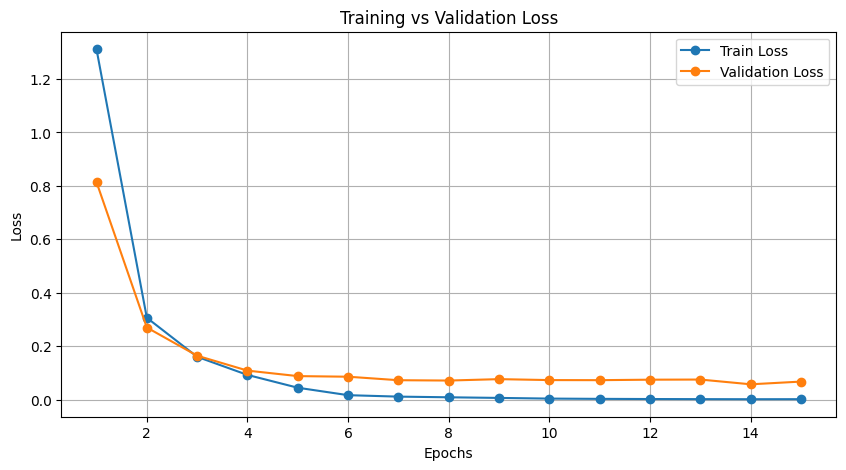

In [ ]:
print(f"----------- Number of Epochs: {NUM_EPOCHS} ------------")

print(f"----------- Batch size: {BATCH_SIZE} ------------")
print(f"----------- device: {DEVICE} ---------------------")

model.train()

num_classes = 6
train_losses = []
val_losses = []

# weighted loss to account for the imbalance of class data
CRITERION = torch.nn.CrossEntropyLoss(weight=torch.Tensor([5, 35, 9, 23, 2, 19]).to(DEVICE))
OPTIMIZER = torch.optim.Adam(model.parameters(), lr=0.01)

scheduler = torch.optim.lr_scheduler.StepLR(OPTIMIZER, step_size=5, gamma=0.5)

model.to(DEVICE)
best_val_acc = 0
for epoch in range(NUM_EPOCHS):
    epoch_train_losses = []
    epoch_val_losses = []
    correct = 0
    total = 0

    for image, label in tqdm(
        TRAIN_DATALOADER, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} - Training"
    ):
        # forward pass
        OPTIMIZER.zero_grad()
        
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        outputs = model(image)

        loss = CRITERION(outputs, label)

        # backward pass (compute gradients of parameters w.r.t. loss)
        loss.backward()

        # optimize
        OPTIMIZER.step()
        epoch_train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        for image, label in tqdm(
            VAL_DATALOADER, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} - Validation"
        ):
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            outputs = model(image)
            # label = F.one_hot(label, num_classes=num_classes).float()
            loss = CRITERION(outputs, label)
            epoch_val_losses.append(loss.item())

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == label).sum().item()
            total += label.size(0)

    train_loss_mean = np.mean(epoch_train_losses)
    val_loss_mean = np.mean(epoch_val_losses)
    val_acc = correct / total

    train_losses.append(train_loss_mean)
    val_losses.append(val_loss_mean)

    print(
        f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {train_loss_mean:.4f} | Val Loss: {val_loss_mean:.4f} | Val Acc: {val_acc:.4f}"
    )
    model.train()
    scheduler.step()

    # Save best model state_dict
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        torch.save(best_model_state, "best_model_state_fc+layer4.pt")


# -------------- PLOTTING --------------
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.savefig("loss_plot.pdf")
plt.show()

# **TRAIN ONE BINARY CLASSIFIER FOR GOOD OR NOT GOOD**

In [13]:
from model import Finetuned_Resnet34

from utils import ImageDataset, ImageDatasetBinaryTrain
import pandas as pd
from torchvision import transforms
import torch
from torch.utils.data import random_split
from torchsummary import summary
from torch.utils.data import DataLoader

image_folder = '../input_train_new'


train_df = pd.read_csv('../Y_train_new.csv')
classes_dict = {
    "GOOD" : 0,
    "Boucle plate" : 1,
    "Lift-off blanc" : 2,
    "Lift-off noir" : 3,
    "Missing" : 4,
    "Short circuit MOS" : 5,
    "Drift" : 6
}
train_df['Label'] = train_df['Label'].replace(classes_dict)


# Transformation des images pour l'entrée du modèle
TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
])

DATASET = ImageDatasetBinaryTrain(image_folder, train_df, transform=TRANSFORM)
train_size = int(0.8 * len(DATASET))
val_size = len(DATASET) - train_size
TRAIN_DATASET, VAL_DATASET = random_split(DATASET, [train_size, val_size])

# Chargement du dataset
BATCH_SIZE = 64

TRAIN_DATALOADER = DataLoader(TRAIN_DATASET, batch_size=BATCH_SIZE, shuffle=True)
VAL_DATALOADER_BINARY = DataLoader(VAL_DATASET, batch_size=BATCH_SIZE, shuffle=False)
# device setup
use_cuda = torch.cuda.is_available()
DEVICE = torch.device('cuda' if use_cuda else 'cpu')


model = Finetuned_Resnet34()

# Train model
model.to(DEVICE)
model.train()
NUM_EPOCHS = 10

# check number of learnable params
summary(model, (3,224,224))

/tmp/ipykernel_400957/3554454988.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['Label'] = train_df['Label'].replace(classes_dict)
/home/emiliopicard/miniconda3/envs/valeo_env2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/emiliopicard/miniconda3/envs/valeo_env2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Wei

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

----------- Number of Epochs: 10 ------------
----------- Batch size: 64 ------------
----------- device: cuda ---------------------


Epoch 1/10 - Training:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 1/10 - Validation: 100%|██████████| 8/8 [00:02<00:00,  2.86it/s]


Epoch 1/10 - Train Loss: 0.0254 | Val Loss: 0.0404 | Val Acc: 0.9940


Epoch 2/10 - Validation: 100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Epoch 2/10 - Train Loss: 0.0033 | Val Loss: 0.0338 | Val Acc: 0.9940


Epoch 3/10 - Validation: 100%|██████████| 8/8 [00:02<00:00,  2.90it/s]


Epoch 3/10 - Train Loss: 0.0006 | Val Loss: 0.0386 | Val Acc: 0.9940


Epoch 4/10 - Validation: 100%|██████████| 8/8 [00:02<00:00,  2.88it/s]


Epoch 4/10 - Train Loss: 0.0000 | Val Loss: 0.0447 | Val Acc: 0.9940


Epoch 5/10 - Validation: 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]


Epoch 5/10 - Train Loss: 0.0001 | Val Loss: 0.0486 | Val Acc: 0.9940


Epoch 6/10 - Validation: 100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Epoch 6/10 - Train Loss: 0.0000 | Val Loss: 0.0400 | Val Acc: 0.9960


Epoch 7/10 - Validation: 100%|██████████| 8/8 [00:02<00:00,  2.87it/s]


Epoch 7/10 - Train Loss: 0.0000 | Val Loss: 0.0399 | Val Acc: 0.9960


Epoch 8/10 - Validation: 100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Epoch 8/10 - Train Loss: 0.0000 | Val Loss: 0.0403 | Val Acc: 0.9960


Epoch 9/10 - Validation: 100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Epoch 9/10 - Train Loss: 0.0000 | Val Loss: 0.0406 | Val Acc: 0.9960


Epoch 10/10 - Validation: 100%|██████████| 8/8 [00:02<00:00,  2.86it/s]


Epoch 10/10 - Train Loss: 0.0000 | Val Loss: 0.0438 | Val Acc: 0.9960


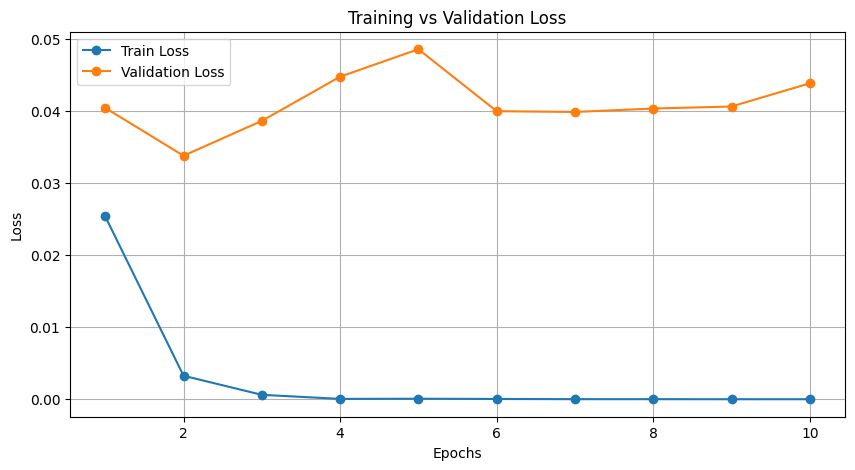

In [16]:
import torch.nn.functional as F
import numpy as np

print(f"----------- Number of Epochs: {NUM_EPOCHS} ------------")

print(f"----------- Batch size: {BATCH_SIZE} ------------")
print(f"----------- device: {DEVICE} ---------------------")

model.train()

num_classes = 2
train_losses = []
val_losses = []

# weighted loss to account for the imbalance of class data
CRITERION = torch.nn.BCEWithLogitsLoss().to(DEVICE)
OPTIMIZER = torch.optim.Adam(model.parameters(), lr=0.01)

scheduler = torch.optim.lr_scheduler.StepLR(OPTIMIZER, step_size=5, gamma=0.5)

model.to(DEVICE)
best_val_acc = 0
for epoch in range(NUM_EPOCHS):
    epoch_train_losses = []
    epoch_val_losses = []
    correct = 0
    total = 0

    for image, label in tqdm(
        TRAIN_DATALOADER, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} - Training"
    ):
        # forward pass
        OPTIMIZER.zero_grad()
        
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        outputs = model(image)
        # outptus = outputs.argmax(1)
        
        # compute loss
        label = F.one_hot(label, num_classes=num_classes).float() # one hot encoding
        # outputs = F.one_hot(outptus, num_classes=num_classes).float()
        loss = CRITERION(outputs, label)

        # backward pass (compute gradients of parameters w.r.t. loss)
        loss.backward()

        # optimize
        OPTIMIZER.step()
        epoch_train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        for image, label in tqdm(
            VAL_DATALOADER, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} - Validation"
        ):
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            outputs = model(image)

            label_hot = F.one_hot(label, num_classes=num_classes).float()
            loss = CRITERION(outputs, label_hot)
            epoch_val_losses.append(loss.item())

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == label).sum().item()
            total += label.size(0)

    train_loss_mean = np.mean(epoch_train_losses)
    val_loss_mean = np.mean(epoch_val_losses)
    val_acc = correct / total

    train_losses.append(train_loss_mean)
    val_losses.append(val_loss_mean)

    print(
        f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {train_loss_mean:.4f} | Val Loss: {val_loss_mean:.4f} | Val Acc: {val_acc:.4f}"
    )
    model.train()
    scheduler.step()

    # Save best model state_dict
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        torch.save(best_model_state, "binary_model_res34_best.pt")


# -------------- PLOTTING --------------
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.savefig("loss_plot.pdf")
plt.show()

# **TRAIN ANOTHER CLASSIFIER JUST FOR NOT GOOD**

In [3]:
from model import Finetuned_Resnet101
from utils import ImageDatasetTrain
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch
from torch.utils.data import DataLoader
import numpy as np
from torchsummary import summary
import shutil

model = Finetuned_Resnet101(num_classes=5)


image_folder = '../input_train_new'


train_df = pd.read_csv('../Y_train_new.csv')
classes_dict = {
    "GOOD" : 0,
    "Boucle plate" : 1,
    "Lift-off blanc" : 2,
    "Lift-off noir" : 3,
    "Missing" : 4,
    "Short circuit MOS" : 5,
    "Drift" : 6
}
train_df['Label'] = train_df['Label'].replace(classes_dict)

# Create a new folder to save the filtered images
filtered_folder = '../input_train_without_GOOD/'
if not os.path.exists(filtered_folder):
    os.makedirs(filtered_folder)

# Filter the dataframe to exclude images with class 0
filtered_df = train_df[train_df['Label'] != 0]

# Copy the filtered images to the new folder
for index, row in filtered_df.iterrows():
    src_path = os.path.join(image_folder, row['filename'])
    dst_path = os.path.join(filtered_folder, row['filename'])
    shutil.copy(src_path, dst_path)

print(f"Copied {len(filtered_df)} images to {filtered_folder}")

# Update the labels to be between 0 and 4
filtered_df['Label'] = filtered_df['Label'] - 1

/home/emiliopicard/miniconda3/envs/valeo_env2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/emiliopicard/miniconda3/envs/valeo_env2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/emiliopicard/miniconda3/envs/valeo_env2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_400957/593

Copied 1843 images to ../input_train_without_GOOD/


/tmp/ipykernel_400957/593491164.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Label'] = filtered_df['Label'] - 1


In [ ]:
# Transformation des images pour l'entrée du modèle
TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
])
image_folder = '../input_train_without_GOOD'
DATASET = ImageDatasetTrain(image_folder, filtered_df, transform=TRANSFORM)
train_size = int(0.8 * len(DATASET))
val_size = len(DATASET) - train_size
TRAIN_DATASET, VAL_DATASET = random_split(DATASET, [train_size, val_size])

BATCH_SIZE = 64

TRAIN_DATALOADER = DataLoader(TRAIN_DATASET, batch_size=BATCH_SIZE, shuffle=True)
VAL_DATALOADER = DataLoader(VAL_DATASET, batch_size=BATCH_SIZE, shuffle=False)

# device setup
use_cuda = torch.cuda.is_available()
DEVICE = torch.device('cuda' if use_cuda else 'cpu')

# Train model
model.to(DEVICE)
model.train()
NUM_EPOCHS = 10

----------- Number of Epochs: 10 ------------
----------- Batch size: 64 ------------
----------- device: cuda ---------------------


Epoch 1/10 - Validation: 100%|██████████| 6/6 [00:03<00:00,  1.85it/s]


Epoch 1/10 - Train Loss: 1.4542 | Val Loss: 30.8311 | Val Acc: 0.7696


Epoch 2/10 - Validation: 100%|██████████| 6/6 [00:03<00:00,  1.86it/s]


Epoch 2/10 - Train Loss: 0.3035 | Val Loss: 1.0889 | Val Acc: 0.4824


Epoch 3/10 - Validation: 100%|██████████| 6/6 [00:03<00:00,  1.73it/s]


Epoch 3/10 - Train Loss: 0.2405 | Val Loss: 0.3647 | Val Acc: 0.9241


Epoch 4/10 - Validation: 100%|██████████| 6/6 [00:03<00:00,  1.93it/s]


Epoch 4/10 - Train Loss: 0.4315 | Val Loss: 0.3439 | Val Acc: 0.9648


Epoch 5/10 - Validation: 100%|██████████| 6/6 [00:03<00:00,  1.92it/s]


Epoch 5/10 - Train Loss: 0.2361 | Val Loss: 0.5312 | Val Acc: 0.9675


Epoch 6/10 - Validation: 100%|██████████| 6/6 [00:03<00:00,  1.89it/s]


Epoch 6/10 - Train Loss: 0.3954 | Val Loss: 0.3626 | Val Acc: 0.9675


Epoch 7/10 - Validation: 100%|██████████| 6/6 [00:03<00:00,  1.70it/s]


Epoch 7/10 - Train Loss: 0.0724 | Val Loss: 11.0341 | Val Acc: 0.9675


Epoch 8/10 - Validation: 100%|██████████| 6/6 [00:03<00:00,  1.75it/s]


Epoch 8/10 - Train Loss: 0.0635 | Val Loss: 6.2712 | Val Acc: 0.9675


Epoch 9/10 - Validation: 100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


Epoch 9/10 - Train Loss: 0.0463 | Val Loss: 3.3925 | Val Acc: 0.9593


Epoch 10/10 - Validation: 100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


Epoch 10/10 - Train Loss: 0.0720 | Val Loss: 21.8957 | Val Acc: 0.9675


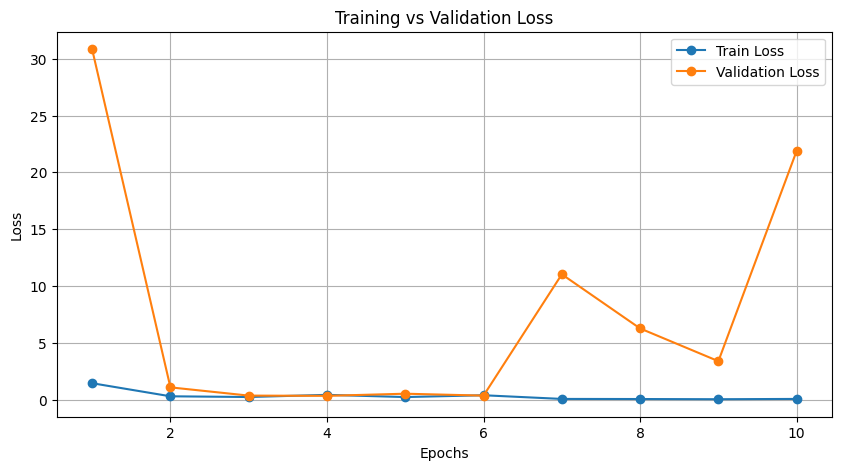

In [7]:
print(f"----------- Number of Epochs: {NUM_EPOCHS} ------------")

print(f"----------- Batch size: {BATCH_SIZE} ------------")
print(f"----------- device: {DEVICE} ---------------------")
NUM_EPOCHS = 10

model.train()

num_classes = 5
train_losses = []
val_losses = []

# weighted loss to account for the imbalance of class data
CRITERION = torch.nn.CrossEntropyLoss(weight=torch.Tensor([35, 9, 23, 2, 19]).to(DEVICE))
OPTIMIZER = torch.optim.Adam(model.parameters(), lr=0.01)

scheduler = torch.optim.lr_scheduler.StepLR(OPTIMIZER, step_size=5, gamma=0.1)

model.to(DEVICE)
best_val_acc = 0
for epoch in range(NUM_EPOCHS):
    epoch_train_losses = []
    epoch_val_losses = []
    correct = 0
    total = 0

    for image, label in tqdm(
        TRAIN_DATALOADER, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} - Training"
    ):
        # forward pass
        OPTIMIZER.zero_grad()
        
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        outputs = model(image)
        # outptus = outputs.argmax(1)
        
        # compute loss
        # label = F.one_hot(label, num_classes=num_classes).float() # one hot encoding
        # outputs = F.one_hot(outptus, num_classes=num_classes).float()
        loss = CRITERION(outputs, label)

        # backward pass (compute gradients of parameters w.r.t. loss)
        loss.backward()

        # optimize
        OPTIMIZER.step()
        epoch_train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        for image, label in tqdm(
            VAL_DATALOADER, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} - Validation"
        ):
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            outputs = model(image)
            # label = F.one_hot(label, num_classes=num_classes).float()
            loss = CRITERION(outputs, label)
            epoch_val_losses.append(loss.item())

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == label).sum().item()
            total += label.size(0)

    train_loss_mean = np.mean(epoch_train_losses)
    val_loss_mean = np.mean(epoch_val_losses)
    val_acc = correct / total

    train_losses.append(train_loss_mean)
    val_losses.append(val_loss_mean)

    print(
        f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {train_loss_mean:.4f} | Val Loss: {val_loss_mean:.4f} | Val Acc: {val_acc:.4f}"
    )
    model.train()
    scheduler.step()

    # Save best model state_dict
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        torch.save(best_model_state, "best_model_5classes.pt")


# -------------- PLOTTING --------------
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.savefig("loss_plot.pdf")
plt.show()

***
# **TRAIN ALL**
***

In [8]:
model_state = torch.load("best_model_5classes.pt", weights_only=False)
model = Finetuned_Resnet101()
model.load_state_dict(model_state)

for param in model.resnet.parameters():
    param.requires_grad_(True)

/home/emiliopicard/miniconda3/envs/valeo_env2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/emiliopicard/miniconda3/envs/valeo_env2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
summary(model.to(DEVICE), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

----------- Number of Epochs: 10 ------------
----------- Batch size: 32 ------------
----------- device: cuda ---------------------


Epoch 1/10 - Validation: 100%|██████████| 12/12 [00:03<00:00,  3.97it/s]


Epoch 1/15 - Train Loss: 0.0859 | Val Loss: 24.7741 | Val Acc: 0.9675


Epoch 2/10 - Validation: 100%|██████████| 12/12 [00:03<00:00,  3.76it/s]


Epoch 2/15 - Train Loss: 0.0661 | Val Loss: 0.3869 | Val Acc: 0.9675


Epoch 3/10 - Validation: 100%|██████████| 12/12 [00:03<00:00,  3.92it/s]


Epoch 3/15 - Train Loss: 0.0274 | Val Loss: 0.3469 | Val Acc: 0.9729


Epoch 4/10 - Validation: 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]


Epoch 4/15 - Train Loss: 0.0283 | Val Loss: 0.3514 | Val Acc: 0.9702


Epoch 5/10 - Validation: 100%|██████████| 12/12 [00:03<00:00,  3.84it/s]


Epoch 5/15 - Train Loss: 0.0166 | Val Loss: 0.3624 | Val Acc: 0.9729


Epoch 6/10 - Validation: 100%|██████████| 12/12 [00:03<00:00,  3.54it/s]


Epoch 6/15 - Train Loss: 0.0098 | Val Loss: 0.3178 | Val Acc: 0.9702


Epoch 7/10 - Validation: 100%|██████████| 12/12 [00:03<00:00,  3.55it/s]


Epoch 7/15 - Train Loss: 0.0948 | Val Loss: 0.4247 | Val Acc: 0.9729


Epoch 8/10 - Validation: 100%|██████████| 12/12 [00:03<00:00,  3.67it/s]


Epoch 8/15 - Train Loss: 0.0261 | Val Loss: 0.4333 | Val Acc: 0.9621


Epoch 9/10 - Validation: 100%|██████████| 12/12 [00:03<00:00,  3.56it/s]


Epoch 9/15 - Train Loss: 0.0153 | Val Loss: 0.4116 | Val Acc: 0.9702


Epoch 10/10 - Validation: 100%|██████████| 12/12 [00:03<00:00,  3.67it/s]


Epoch 10/15 - Train Loss: 0.0300 | Val Loss: 0.4538 | Val Acc: 0.9702


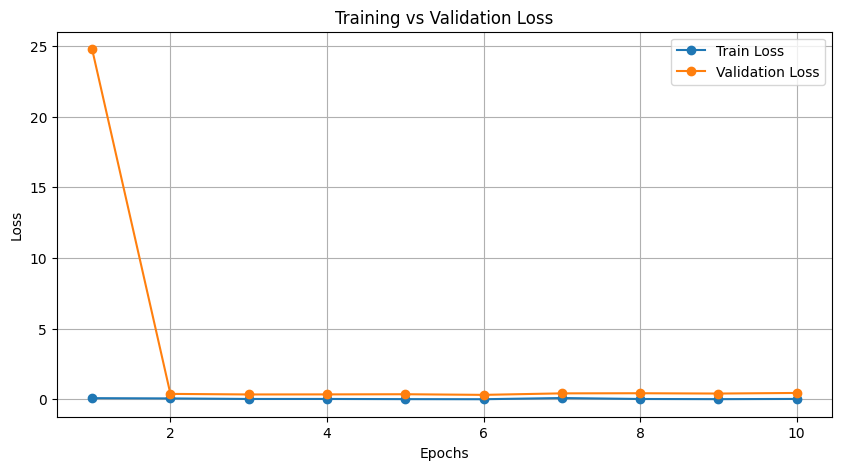

In [10]:
print(f"----------- Number of Epochs: {10} ------------")

print(f"----------- Batch size: {32} ------------")
print(f"----------- device: {DEVICE} ---------------------")


model.train()

num_classes = 5
train_losses = []
val_losses = []

TRAIN_DATALOADER = DataLoader(TRAIN_DATASET, batch_size=32, shuffle=True)
VAL_DATALOADER = DataLoader(VAL_DATASET, batch_size=32, shuffle=False)

# weighted loss to account for the imbalance of class data
CRITERION = torch.nn.CrossEntropyLoss(weight=torch.Tensor([100, 31, 80, 1, 66]).to(DEVICE))
OPTIMIZER = torch.optim.Adam(model.parameters(), lr=0.00001)

# scheduler = torch.optim.lr_scheduler.StepLR(OPTIMIZER, step_size=5, gamma=0.8)

model.to(DEVICE)
for epoch in range(10):
    epoch_train_losses = []
    epoch_val_losses = []
    correct = 0
    total = 0

    for image, label in tqdm(
        TRAIN_DATALOADER, desc=f"Epoch {epoch+1}/{10} - Training"
    ):
        # forward pass
        OPTIMIZER.zero_grad()
        
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        outputs = model(image)
        # outptus = outputs.argmax(1)
        
        # compute loss
        # label = F.one_hot(label, num_classes=num_classes).float() # one hot encoding
        # outputs = F.one_hot(outptus, num_classes=num_classes).float()
        loss = CRITERION(outputs, label)

        # backward pass (compute gradients of parameters w.r.t. loss)
        loss.backward()

        # optimize
        OPTIMIZER.step()
        epoch_train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        for image, label in tqdm(
            VAL_DATALOADER, desc=f"Epoch {epoch+1}/{10} - Validation"
        ):
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            outputs = model(image)
            
            # label = F.one_hot(label, num_classes=num_classes).float()
            loss = CRITERION(outputs, label)
            epoch_val_losses.append(loss.item())
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == label).sum().item()
            total += label.size(0)
    
    train_loss_mean = np.mean(epoch_train_losses)
    val_loss_mean = np.mean(epoch_val_losses)

    train_losses.append(train_loss_mean)
    val_losses.append(val_loss_mean)
    val_acc = correct / total
    # scheduler.step()

    print(
        f"Epoch {epoch+1}/{15} - Train Loss: {train_loss_mean:.4f} | Val Loss: {val_loss_mean:.4f} | Val Acc: {val_acc:.4f}"
    )
    model.train()
    # Save best model state_dict
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        torch.save(best_model_state, "resnet_5classes_all_best.pt")


# -------------- PLOTTING --------------
plt.figure(figsize=(10, 5))
plt.plot(range(1, 10 + 1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, 10 + 1), val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.savefig("loss_plot.pdf")
plt.show()

/home/emiliopicard/miniconda3/envs/valeo_env2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/emiliopicard/miniconda3/envs/valeo_env2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy for binary_model_res34_best: 1.0000


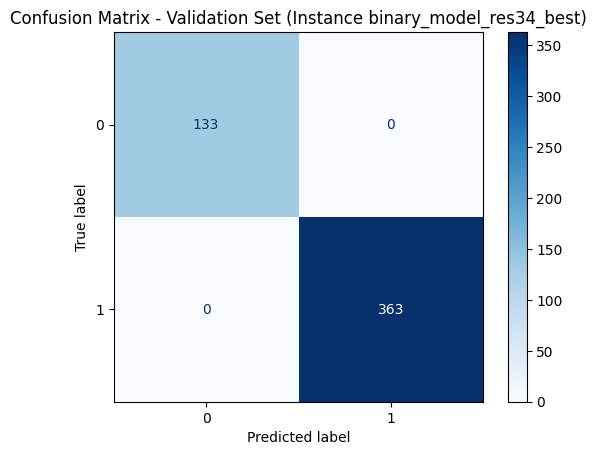

/home/emiliopicard/miniconda3/envs/valeo_env2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/emiliopicard/miniconda3/envs/valeo_env2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy for resnet_5classes_all_best: 0.9756


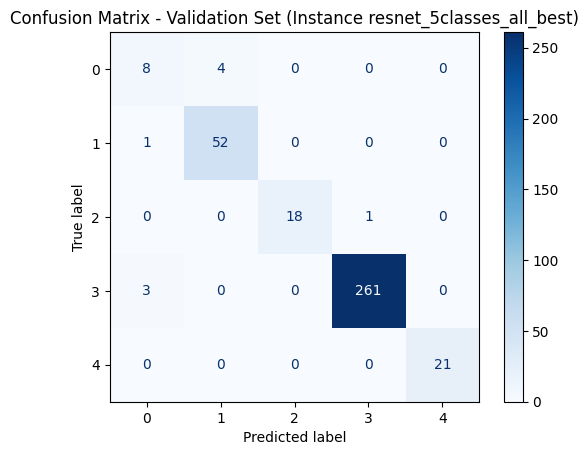

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from model import Finetuned_Resnet101, Finetuned_Resnet34

import matplotlib.pyplot as plt

# Plot confusion matrix for each instance
for idc, instance in enumerate(['binary_model_res34_best', 'resnet_5classes_all_best']):
    # Load the model state for the current instance
    if idc == 0:
        model = Finetuned_Resnet34()
    else:
        model = Finetuned_Resnet101()
    model_state = torch.load(f"{instance}.pt", weights_only=False)
    model.load_state_dict(model_state)

    model.to(DEVICE)
    true_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        if idc == 0:
            val_data = VAL_DATALOADER_BINARY
        else:
            val_data = VAL_DATALOADER
        for image, label in val_data:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(label.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    # Compute accuracy
    accuracy = np.sum(np.array(true_labels) == np.array(predicted_labels)) / len(true_labels)
    print(f'Accuracy for {instance}: {accuracy:.4f}')
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - Validation Set (Instance {instance})')
    plt.show()

[('0f2ac3a3c12dcb5d4f64638b249fe8fcbdc413642650358025cd62b8ba2906ac.png', np.int64(2), np.int64(1)), ('79c7d4e428417952fc38a0a1dc835e589c628dccd36a3bf02237d933eb89e695.png', np.int64(5), np.int64(0)), ('0be7824d32410341d34156a3f444aa85b1e3361fdd565ca2f69fe425a9f869d6.png', np.int64(1), np.int64(2)), ('3ec9fef886e302470938f386936326090eae7a3c9149377296e514185a541136.png', np.int64(2), np.int64(3)), ('800b9e0dad935841df315f820361feb052cd8e275fb4d39a9f95ba974efa5083.png', np.int64(2), np.int64(0)), ('ed72c85b9a75ba3a12e01445faf30e64354bf34efa86658a259bb8f37d8d6292.png', np.int64(1), np.int64(2)), ('4d2aa38f49c1cd8b3bce6cb86cc308fc950aeb7bfd3c7e85a16453bb30630158.png', np.int64(3), np.int64(2)), ('aae2d7c3600017499af1bc7979c6dbef9b1b57540913afc4dad272247bb2df00.png', np.int64(1), np.int64(2))]


***
# **Evaluate both classifiers**
***

In [6]:
from model import Finetuned_Resnet101, Finetuned_Resnet34

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from utils import ImageDataset
import torch.nn.functional as F

# Transformation des images pour l'entrée du modèle
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
])

image_folder1 = '../input_train_without_GOOD/'
dataset_test1 = ImageDataset(image_folder1, transform=transform)
dataloader1 = DataLoader(dataset_test1, batch_size=1, shuffle=False)

image_folder2 = '../input_train_new/'
dataset_test2 = ImageDataset(image_folder2, transform=transform)
dataloader2 = DataLoader(dataset_test2, batch_size=1, shuffle=False)


# device setup
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

# Load classifier model
# model = torch.load("finetuned_model_ALL.pt", weights_only=False)
model_state_1 = torch.load("resnet_5classes_all_best.pt", weights_only=False)
model1 = Finetuned_Resnet101()
model1.load_state_dict(model_state_1)
model1.to(device)
model1.eval()

model_state_2 = torch.load("binary_model_res34_best.pt", weights_only=False)
model2 = Finetuned_Resnet34()
model2.load_state_dict(model_state_2)
model2.to(device)
model2.eval()

# Passer les images dans le modèle
y_pred_classifier = []
filenames_list = []
output_classifier1=[]
output_classifier2=[]

phase = ['binary', 'classify']
for mode in phase:
    print(f"phase = {mode}")
    with torch.no_grad():  # Désactive le calcul des gradients
        dataloader = dataloader1 if mode == "classify" else dataloader2
        model = model1 if mode == "classify" else model2
        output_classifier = output_classifier1 if mode == "classify" else output_classifier2
        for images, filenames in tqdm(dataloader):
            images = images.to(device)
            outputs = model(images)
            outputs = F.softmax(outputs, dim=1)
            # Move the outputs to CPU and convert to numpy
            output_classifier.extend(outputs.cpu().numpy())
            filenames_list.extend(filenames)  # Ajouter les noms de fichiers

# Store scores and filenames
for filename, score in zip(filenames_list, output_classifier1):
    y_pred_classifier.append((filename, score))

print(y_pred_classifier)

/home/emiliopicard/miniconda3/envs/valeo_env2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/emiliopicard/miniconda3/envs/valeo_env2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/emiliopicard/miniconda3/envs/valeo_env2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_

phase = binary


100%|██████████| 2478/2478 [00:30<00:00, 81.11it/s]


phase = classify


100%|██████████| 1843/1843 [00:42<00:00, 43.70it/s]


[('754909ae3bf7efc5768b079b7e6daf8098308da9cde06af523043504a0d06ef1.png', array([1.3503293e-05, 1.8457387e-04, 7.8581397e-06, 9.9979299e-01,
       1.0344071e-06], dtype=float32)), ('e218c6d1f3cdd68204502adc2f0cde192e611512b5412dce563c5e66224644a6.png', array([0.3665661 , 0.04443852, 0.01436352, 0.5658425 , 0.00878937],
      dtype=float32)), ('03e51595a22ee0022822aa4813db35f5122d8bbb1dc07ee1f70e02bd8563b869.png', array([0.13921404, 0.02558229, 0.02540731, 0.8037393 , 0.00605706],
      dtype=float32)), ('bf865d3e8b9c7805e53a746530166ddfd778b45af92eee7c4faad30a1a694237.png', array([9.8947573e-01, 9.8283691e-03, 3.6925214e-04, 1.9810510e-05,
       3.0696392e-04], dtype=float32)), ('b3eff72a2a9088208653182880f31e4851529c5a6bfc3d09690ceecf84478a9e.png', array([2.2369584e-06, 2.3932231e-04, 4.9886617e-06, 9.9975270e-01,
       7.0328366e-07], dtype=float32)), ('cb4a6ac643a89f922145b8f6f2f9f44eb16aea661fc76747c1e8ad2fb62306f6.png', array([0., 0., 0., 1., 0.], dtype=float32)), ('525587cc103

In [24]:
y_pred_good = []
for filename, score in zip(filenames_list, output_classifier2):
    y_pred_good.append((filename, score))

In [25]:
# Convertir y_pred_anomaly en un dictionnaire
y_pred_good_dict = dict(y_pred_good)

# Convertir y_pred_classifier en un dictionnaire
classifier_dict = dict(y_pred_classifier)

# Fusionner les deux dictionnaires basés sur le filename
# Assurer que tous les filenames sont présents dans les deux modèles
merged_data = []
for filename in y_pred_good_dict.keys():
    if filename in classifier_dict:
        good_score = y_pred_good_dict[filename][0]
        classifier_probs = classifier_dict[filename]
        merged_data.append((filename, good_score, *classifier_probs))  # Fusionner les données

# Créer un DataFrame pandas avec les résultats
final_df = pd.DataFrame(merged_data, columns=['filename', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5'])

In [26]:
#### Get the y_test
train_labels = '../Y_train_new.csv'
train_df = pd.read_csv(train_labels)

classes_dict = {
    "GOOD" : 0,
    "Boucle plate" : 1,
    "Lift-off blanc" : 2,
    "Lift-off noir" : 3,
    "Missing" : 4,
    "Short circuit MOS" : 5,
    "Drift" : 6
}

# Replace the labels by the corresponding vlaues in the dict

train_df['Label'] = train_df['Label'].replace(classes_dict)

# Check the new values
train_df['Label'].unique()


/tmp/ipykernel_1794/253729427.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['Label'] = train_df['Label'].replace(classes_dict)


array([0, 4, 1, 2, 3, 5])

In [27]:
# merge the results and true results DFs
merged_df = pd.merge(final_df, train_df, on='filename', how='inner')

In [28]:
merged_df.head()

,filename,p0,p1,p2,p3,p4,p5,Unnamed: 0,window,lib,Label
0,754909ae3bf7efc5768b079b7e6daf8098308da9cde06a...,3.312211e-16,0.000014,0.000185,0.000008,0.999793,1.034407e-06,6639,2005,Die03,4
1,e218c6d1f3cdd68204502adc2f0cde192e611512b5412d...,1.415018e-13,0.366566,0.044439,0.014364,0.565843,8.789367e-03,5632,2003,Die01,4
2,03e51595a22ee0022822aa4813db35f5122d8bbb1dc07e...,5.855113e-14,0.139214,0.025582,0.025407,0.803739,6.057062e-03,2866,2003,Die01,4
3,bf865d3e8b9c7805e53a746530166ddfd778b45af92eee...,2.039316e-18,0.989476,0.009828,0.000369,0.000020,3.069639e-04,5264,2003,Die04,1
4,b3eff72a2a9088208653182880f31e4851529c5a6bfc3d...,2.167299e-14,0.000002,0.000239,0.000005,0.999753,7.032837e-07,4412,2005,Die04,4


In [29]:
def define_good_classes_and_others(row, threshold=0.5):
    # Accéder à la valeur de p_drift dans la ligne
    p_good = row['p0']
    # Extraire les probabilités des classes (colonnes 2 à 7)
    p_classes = row[['p1', 'p2', 'p3', 'p4', 'p5']].values
    # Si le drift est supérieur au seuil, retourner 6, sinon index du max des classes
    if p_good >= threshold:
        return 0
    # else:
    return p_classes.argmax() + 1  # Utiliser argmax pour obtenir l'indice du max

merged_df['y_pred'] = merged_df.apply(define_good_classes_and_others, axis=1)

In [31]:
merged_df.head()

,filename,p0,p1,p2,p3,p4,p5,Unnamed: 0,window,lib,Label,y_pred
0,754909ae3bf7efc5768b079b7e6daf8098308da9cde06a...,3.312211e-16,0.000014,0.000185,0.000008,0.999793,1.034407e-06,6639,2005,Die03,4,4
1,e218c6d1f3cdd68204502adc2f0cde192e611512b5412d...,1.415018e-13,0.366566,0.044439,0.014364,0.565843,8.789367e-03,5632,2003,Die01,4,4
2,03e51595a22ee0022822aa4813db35f5122d8bbb1dc07e...,5.855113e-14,0.139214,0.025582,0.025407,0.803739,6.057062e-03,2866,2003,Die01,4,4
3,bf865d3e8b9c7805e53a746530166ddfd778b45af92eee...,2.039316e-18,0.989476,0.009828,0.000369,0.000020,3.069639e-04,5264,2003,Die04,1,1
4,b3eff72a2a9088208653182880f31e4851529c5a6bfc3d...,2.167299e-14,0.000002,0.000239,0.000005,0.999753,7.032837e-07,4412,2005,Die04,4,4


In [32]:
import numpy as np

def penalty_weighted_accuracy(y_true, y_pred, penalty_matrix):
    total_penalty = 0
    max_penalty = penalty_matrix.max()  # Maximum possible penalty in the matrix
    n = len(y_true)  # Total number of samples

    for i in range(n):
        true_class = y_true[i]
        predicted_class = y_pred[i]
        
        # If misclassified, add the penalty; if correct, penalty is 0
        if true_class != predicted_class:
            total_penalty += penalty_matrix[true_class, predicted_class]
    
    # Normalize penalty by the worst-case penalty (n * max_penalty)
    normalized_penalty = total_penalty / (n * max_penalty)
    
    # Calculate PWA
    pwa = 1 - normalized_penalty
    return pwa

# Define the penalty matrix based on the design example
penalty_matrix = np.array([
    [0, 100, 100, 100, 100, 100, 10000],    # Good
    [10000, 0, 1, 1, 1, 1, 1000],           # Defect1
    [10000, 1, 0, 1, 1, 1, 1000],           # Defect2
    [10000, 1, 1, 0, 1, 1, 1000],           # Defect3
    [10000, 1, 1, 1, 0, 1, 1000],           # Defect4
    [10000, 1, 1, 1, 1, 0, 1000],           # Defect5
    [10000, 1000, 1000, 1000, 1000, 1000, 0] # Drift
])

# Calculate Penalty-Weighted Accuracy
pwa = penalty_weighted_accuracy(merged_df['Label'], merged_df['y_pred'], penalty_matrix)
print(f"Penalty-Weighted Accuracy: {pwa}")

Penalty-Weighted Accuracy: 0.9994214324470971


***
# **Classifier** - EVALUATE:
***

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from utils import ImageDataset
import torch.nn.functional as F

# Transformation des images pour l'entrée du modèle
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
])

image_folder1 = '../input_train_without_GOOD/'
dataset_test1 = ImageDataset(image_folder1, transform=transform)
dataloader1 = DataLoader(dataset_test1, batch_size=1, shuffle=False)

image_folder2 = '../input_train_new/'
dataset_test2 = ImageDataset(image_folder2, transform=transform)
dataloader2 = DataLoader(dataset_test2, batch_size=1, shuffle=False)


# device setup
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

# Load classifier model
# model = torch.load("finetuned_model_ALL.pt", weights_only=False)
model_state_1 = torch.load("resnet_5classes_all_best.pt", weights_only=False)
model1 = Finetuned_Resnet101()
model1.load_state_dict(model_state_1)
model1.to(device)
model1.eval()

model_state_2 = torch.load("binary_model_res34_best.pt", weights_only=False)
model2 = Finetuned_Resnet34()
model2.load_state_dict(model_state_2)
model2.to(device)
model2.eval()

# Passer les images dans le modèle
y_pred_classifier = []
filenames_list = []
output_classifier1=[]
output_classifier2=[]

phase = ['binary', 'classify']
for mode in phase:
    print(f"phase = {mode}")
    with torch.no_grad():  # Désactive le calcul des gradients
        dataloader = dataloader1 if mode == "classify" else dataloader2
        model = model1 if mode == "classify" else model2
        output_classifier = output_classifier1 if mode == "classify" else output_classifier2
        for images, filenames in tqdm(dataloader):
            images = images.to(device)
            outputs = model(images)
            outputs = F.softmax(outputs, dim=1)
            # Move the outputs to CPU and convert to numpy
            output_classifier.extend(outputs.cpu().numpy())
            filenames_list.extend(filenames)  # Ajouter les noms de fichiers

# Store scores and filenames
for filename, score in zip(filenames_list, output_classifier1):
    y_pred_classifier.append((filename, score))

print(y_pred_classifier)

/home/emiliopicard/miniconda3/envs/valeo_env2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/emiliopicard/miniconda3/envs/valeo_env2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/emiliopicard/miniconda3/envs/valeo_env2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_

phase = binary


100%|██████████| 2478/2478 [00:46<00:00, 53.62it/s]


phase = classify


100%|██████████| 1843/1843 [01:13<00:00, 25.06it/s]


[('754909ae3bf7efc5768b079b7e6daf8098308da9cde06af523043504a0d06ef1.png', array([1.3503293e-05, 1.8457387e-04, 7.8581397e-06, 9.9979299e-01,
       1.0344071e-06], dtype=float32)), ('e218c6d1f3cdd68204502adc2f0cde192e611512b5412dce563c5e66224644a6.png', array([0.3665661 , 0.04443852, 0.01436352, 0.5658425 , 0.00878937],
      dtype=float32)), ('03e51595a22ee0022822aa4813db35f5122d8bbb1dc07ee1f70e02bd8563b869.png', array([0.13921404, 0.02558229, 0.02540731, 0.8037393 , 0.00605706],
      dtype=float32)), ('bf865d3e8b9c7805e53a746530166ddfd778b45af92eee7c4faad30a1a694237.png', array([9.8947573e-01, 9.8283691e-03, 3.6925214e-04, 1.9810510e-05,
       3.0696392e-04], dtype=float32)), ('b3eff72a2a9088208653182880f31e4851529c5a6bfc3d09690ceecf84478a9e.png', array([2.2369584e-06, 2.3932231e-04, 4.9886617e-06, 9.9975270e-01,
       7.0328366e-07], dtype=float32)), ('cb4a6ac643a89f922145b8f6f2f9f44eb16aea661fc76747c1e8ad2fb62306f6.png', array([0., 0., 0., 1., 0.], dtype=float32)), ('525587cc103

### Calcul de la performance

In [129]:
classifier_dict = dict(y_pred_classifier)
merge_data = []
for filename in classifier_dict.keys():
    classifier_probs = classifier_dict[filename]
    merge_data.append((filename, 0, *classifier_probs))

final_df = pd.DataFrame(merge_data, columns=['filename', 'p_drift', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5'])

In [130]:
final_df.head()

,filename,p_drift,p0,p1,p2,p3,p4,p5
0,8444939422ab1a3d15cec68d15ac1c67ac70cb5e1364e7...,0,9.999988e-01,4.004343e-11,1.580097e-11,6.865870e-10,7.058335e-11,1.152126e-06
1,c3aadec0357dd1b714b992c6606b51dfc2c49043ee467c...,0,6.593098e-11,2.471350e-06,1.521949e-06,3.561071e-09,9.999931e-01,2.909808e-06
2,390b340b597fb4712a555f1b9b974d19e924c37739d6f3...,0,1.000000e+00,3.155556e-10,9.803044e-13,6.229275e-11,1.304393e-11,4.988092e-08
3,d0512ec8979ddd24d4f711fa23fceb4269f4ba9cc43f08...,0,6.798573e-10,1.632887e-05,5.441388e-05,6.338013e-08,9.999201e-01,9.115899e-06
4,0c6e5ee3b4e584e6bdb5f13638050c50813aa49c9ee5bd...,0,9.999936e-01,7.030600e-09,1.343124e-10,1.026018e-09,2.308271e-09,6.413408e-06


In [131]:
#### Get the y_test
train_labels = '../Y_train_new.csv'
train_df = pd.read_csv(train_labels)

classes_dict = {
    "GOOD" : 0,
    "Boucle plate" : 1,
    "Lift-off blanc" : 2,
    "Lift-off noir" : 3,
    "Missing" : 4,
    "Short circuit MOS" : 5,
    "Drift" : 6
}

# Replace the labels by the corresponding vlaues in the dict

train_df['Label'] = train_df['Label'].replace(classes_dict)

# Check the new values
train_df['Label'].unique()


/tmp/ipykernel_949/253729427.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['Label'] = train_df['Label'].replace(classes_dict)


array([0, 4, 1, 2, 3, 5])

In [132]:
# merge the results and true results DFs
merged_df = pd.merge(final_df, train_df, on='filename', how='inner')

In [133]:
merged_df.head()

,filename,p_drift,p0,p1,p2,p3,p4,p5,Unnamed: 0,window,lib,Label
0,8444939422ab1a3d15cec68d15ac1c67ac70cb5e1364e7...,0,9.999988e-01,4.004343e-11,1.580097e-11,6.865870e-10,7.058335e-11,1.152126e-06,2001,2005,Die02,0
1,c3aadec0357dd1b714b992c6606b51dfc2c49043ee467c...,0,6.593098e-11,2.471350e-06,1.521949e-06,3.561071e-09,9.999931e-01,2.909808e-06,4239,2005,Die03,4
2,390b340b597fb4712a555f1b9b974d19e924c37739d6f3...,0,1.000000e+00,3.155556e-10,9.803044e-13,6.229275e-11,1.304393e-11,4.988092e-08,7444,2003,Die01,0
3,d0512ec8979ddd24d4f711fa23fceb4269f4ba9cc43f08...,0,6.798573e-10,1.632887e-05,5.441388e-05,6.338013e-08,9.999201e-01,9.115899e-06,4676,2003,Die02,4
4,0c6e5ee3b4e584e6bdb5f13638050c50813aa49c9ee5bd...,0,9.999936e-01,7.030600e-09,1.343124e-10,1.026018e-09,2.308271e-09,6.413408e-06,1456,2005,Die01,0


In [138]:
import numpy as np

def define_classe(row, threshold=0.5):
    # Accéder à la valeur de p_drift dans la ligne
    p_drift = row['p_drift']
    
    # Extraire les probabilités des classes (colonnes 2 à 7)
    p_classes = row[['p0', 'p1', 'p2', 'p3', 'p4', 'p5']].values
    # Si le drift est supérieur au seuil, retourner 6, sinon index du max des classes
    if p_drift >= threshold:
        return 6
    # else:
    return p_classes.argmax()  # Utiliser argmax pour obtenir l'indice du max


def define_classe_chit(row, threshold=0.5, threshold_good=0.8):
    # Accéder à la valeur de p_drift dans la ligne
    p_drift = row['p_drift']
    
    # Extraire les probabilités des classes (colonnes 2 à 7)
    p_classes = row[['p0', 'p1', 'p2', 'p3', 'p4', 'p5']].values
    
    # Si le drift est supérieur au seuil, retourner 6, sinon index du max des classes
    if p_drift > threshold:
        return 6
    else:
        if np.argmax(p_classes) == 0 and p_classes[0] < threshold_good:
            second_max_idx = np.argsort(p_classes)[-2]
            print("changing prediction")
            return second_max_idx
        else:
            return p_classes.argmax()  # Utiliser argmax pour obtenir l'indice du max


# Appliquer la fonction à chaque ligne du DataFrame
merged_df['y_pred'] = final_df.apply(define_classe_chit, axis=1)

In [139]:
merged_df.head()

,filename,p_drift,p0,p1,p2,p3,p4,p5,Unnamed: 0,window,lib,Label,y_pred
0,8444939422ab1a3d15cec68d15ac1c67ac70cb5e1364e7...,0,9.999988e-01,4.004343e-11,1.580097e-11,6.865870e-10,7.058335e-11,1.152126e-06,2001,2005,Die02,0,0
1,c3aadec0357dd1b714b992c6606b51dfc2c49043ee467c...,0,6.593098e-11,2.471350e-06,1.521949e-06,3.561071e-09,9.999931e-01,2.909808e-06,4239,2005,Die03,4,4
2,390b340b597fb4712a555f1b9b974d19e924c37739d6f3...,0,1.000000e+00,3.155556e-10,9.803044e-13,6.229275e-11,1.304393e-11,4.988092e-08,7444,2003,Die01,0,0
3,d0512ec8979ddd24d4f711fa23fceb4269f4ba9cc43f08...,0,6.798573e-10,1.632887e-05,5.441388e-05,6.338013e-08,9.999201e-01,9.115899e-06,4676,2003,Die02,4,4
4,0c6e5ee3b4e584e6bdb5f13638050c50813aa49c9ee5bd...,0,9.999936e-01,7.030600e-09,1.343124e-10,1.026018e-09,2.308271e-09,6.413408e-06,1456,2005,Die01,0,0


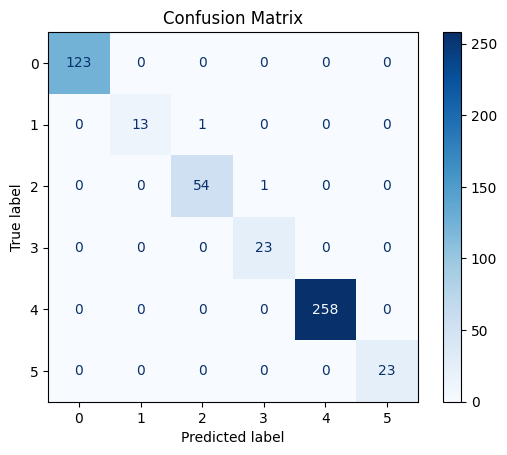

In [140]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Extract true labels and predicted labels
true_labels = merged_df['Label']
predicted_labels = merged_df['y_pred']

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [141]:
import numpy as np

def penalty_weighted_accuracy(y_true, y_pred, penalty_matrix):
    total_penalty = 0
    max_penalty = penalty_matrix.max()  # Maximum possible penalty in the matrix
    n = len(y_true)  # Total number of samples

    for i in range(n):
        true_class = y_true[i]
        predicted_class = y_pred[i]
        
        # If misclassified, add the penalty; if correct, penalty is 0
        if true_class != predicted_class:
            total_penalty += penalty_matrix[true_class, predicted_class]
    
    # Normalize penalty by the worst-case penalty (n * max_penalty)
    normalized_penalty = total_penalty / (n * max_penalty)
    
    # Calculate PWA
    pwa = 1 - normalized_penalty
    return pwa

# Define the penalty matrix based on the design example
penalty_matrix = np.array([
    [0, 100, 100, 100, 100, 100, 10000],    # Good
    [10000, 0, 1, 1, 1, 1, 1000],           # Defect1
    [10000, 1, 0, 1, 1, 1, 1000],           # Defect2
    [10000, 1, 1, 0, 1, 1, 1000],           # Defect3
    [10000, 1, 1, 1, 0, 1, 1000],           # Defect4
    [10000, 1, 1, 1, 1, 0, 1000],           # Defect5
    [10000, 1000, 1000, 1000, 1000, 1000, 0] # Drift
])

# Calculate Penalty-Weighted Accuracy
pwa = penalty_weighted_accuracy(merged_df['Label'], merged_df['y_pred'], penalty_matrix)
print(f"Penalty-Weighted Accuracy: {pwa}")

Penalty-Weighted Accuracy: 0.9999995967741936


# CREER LE CSV

In [65]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from utils import ImageDataset

# Transformation des images pour l'entrée du modèle
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
])

image_folder = '../input_test_rotcrop/'

dataset_test = ImageDataset(image_folder, transform=transform)
dataloader = DataLoader(dataset_test, batch_size=1, shuffle=False)

# device setup
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

# Load classifier model
# model = torch.load("finetuned_model_ALL.pt", weights_only=False)
model_state = torch.load("best_model_state_fc+layer4.pt", weights_only=False)
model = Finetuned_Resnet101()
model.load_state_dict(model_state)
model.to(device)
model.eval()  

# Passer les images dans le modèle
y_pred_classifier = []
filenames_list = []
output_classifier=[]

with torch.no_grad():  # Désactive le calcul des gradients
    for images, filenames in tqdm(dataloader):
        images = images.to(device)
        outputs = model(images)
        outputs = F.softmax(outputs, dim=1)
        # Move the outputs to CPU and convert to numpy
        output_classifier.extend(outputs.cpu().numpy())
        filenames_list.extend(filenames)  # Ajouter les noms de fichiers

# Store scores and filenames
for filename, score in zip(filenames_list, output_classifier):
    y_pred_classifier.append((filename, score))

print(y_pred_classifier)

/home/emiliopicard/miniconda3/envs/valeo_env2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/emiliopicard/miniconda3/envs/valeo_env2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 1055/1055 [00:23<00:00, 45.85it/s]

[('6d92b4bc7045add5b8d2d1bd36a2662974f5c94d36898f661fdd5f7c572e3251.png', array([2.5774609e-06, 6.5036205e-04, 1.2782639e-03, 8.7822831e-05,
       9.9774796e-01, 2.3293839e-04], dtype=float32)), ('0cbd0564f4727ea215e8d23ba4b73a6cfee3a82562a7a75e51fa30bf1df7e1d0.png', array([9.9659193e-01, 9.0878591e-04, 5.1009247e-05, 1.1417855e-03,
       1.5322197e-05, 1.2912406e-03], dtype=float32)), ('efb1f7dbdb0afffc4235fb68ca8b1b3ccfd3d06cffb8f031bc09539d54115136.png', array([2.1918693e-06, 1.3827084e-02, 2.2108508e-03, 2.6883735e-04,
       8.0690914e-01, 1.7678186e-01], dtype=float32)), ('4774ea626d257b9701b14d41b892e3b8100c6628beef30eeb3619c5a5715d12f.png', array([3.0484402e-05, 8.7731645e-02, 4.1515171e-03, 3.9888345e-04,
       9.0594834e-01, 1.7390823e-03], dtype=float32)), ('85baf43711651e8bd8b1e223f4820f6e34c212c4e8a7472fd67c22ac21a16a50.png', array([2.3624389e-10, 4.9384204e-07, 2.4642964e-06, 2.1180493e-09,
       9.9999654e-01, 4.3352875e-07], dtype=float32)), ('40f65fcbbcd6d276a540dc

In [72]:
# Check classifier predictions lenght = anomaly detection prediction length

if len(y_pred_classifier) != len(y_pred_anomaly):
    print("Erreur: les deux prédictions n'ont pas la meme dimension")

In [88]:
# Convertir y_pred_anomaly en un dictionnaire
anomaly_dict = dict(y_pred_anomaly)

# Convertir y_pred_classifier en un dictionnaire
classifier_dict = dict(y_pred_classifier)

# Fusionner les deux dictionnaires basés sur le filename
# Assurer que tous les filenames sont présents dans les deux modèles
merged_data = []
for filename in anomaly_dict.keys():
    if filename in classifier_dict:
        anomaly_score = anomaly_dict[filename]
        classifier_probs = classifier_dict[filename]
        merged_data.append((filename, anomaly_score, *classifier_probs))  # Fusionner les données

# Créer un DataFrame pandas avec les résultats
final_df = pd.DataFrame(merged_data, columns=['filename', 'p_drift', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5'])

In [89]:
final_df.head()

,filename,p_drift,p0,p1,p2,p3,p4,p5
0,14fba6896255e25133ecc7e84a62b02aab12d04ee96987...,0.558065,9.946086e-01,9.050306e-04,6.100771e-05,1.262893e-03,3.405193e-05,3.128272e-03
1,46f4b16aa4459b0f6c7a2d12071ecbf9569ff16da324e3...,0.425671,9.999976e-01,5.203712e-10,1.047733e-10,5.704163e-09,2.934190e-10,2.391078e-06
2,530d31f6e2cc42716e3f25df51162e87aa8ac9a04e918a...,0.262214,1.097929e-06,2.486972e-04,1.303820e-03,1.952213e-05,9.982544e-01,1.725506e-04
3,d89ad9479b90f2a5afcc4662d29eb8d4307e5ff2bcb644...,0.791487,1.518882e-05,1.619951e-03,1.262570e-02,5.965672e-04,9.838361e-01,1.306457e-03
4,134b6dff02c8fbe89816111ac7fe19b7baeb83a8f86006...,0.194050,4.810126e-13,5.015873e-08,2.273193e-08,1.182825e-11,9.999998e-01,1.527404e-07


In [90]:
# merge the results and true results DFs
wid_lib_df = pd.read_csv('win_and_lib.csv')
merged_df = pd.merge(final_df, wid_lib_df, on='filename', how='inner')

In [91]:
merged_df.head()

,filename,p_drift,p0,p1,p2,p3,p4,p5,window,lib
0,14fba6896255e25133ecc7e84a62b02aab12d04ee96987...,0.558065,9.946086e-01,9.050306e-04,6.100771e-05,1.262893e-03,3.405193e-05,3.128272e-03,2003,Die03
1,46f4b16aa4459b0f6c7a2d12071ecbf9569ff16da324e3...,0.425671,9.999976e-01,5.203712e-10,1.047733e-10,5.704163e-09,2.934190e-10,2.391078e-06,2005,Die02
2,530d31f6e2cc42716e3f25df51162e87aa8ac9a04e918a...,0.262214,1.097929e-06,2.486972e-04,1.303820e-03,1.952213e-05,9.982544e-01,1.725506e-04,2003,Die01
3,d89ad9479b90f2a5afcc4662d29eb8d4307e5ff2bcb644...,0.791487,1.518882e-05,1.619951e-03,1.262570e-02,5.965672e-04,9.838361e-01,1.306457e-03,2005,Die01
4,134b6dff02c8fbe89816111ac7fe19b7baeb83a8f86006...,0.194050,4.810126e-13,5.015873e-08,2.273193e-08,1.182825e-11,9.999998e-01,1.527404e-07,2005,Die03


In [92]:
import numpy as np

def define_classe(row, threshold=0.5):
    # Accéder à la valeur de p_drift dans la ligne
    p_drift = row['p_drift']
    
    # Extraire les probabilités des classes (colonnes 2 à 7)
    p_classes = row[['p0', 'p1', 'p2', 'p3', 'p4', 'p5']].values
    
    # Si le drift est supérieur au seuil, retourner 6, sinon index du max des classes
    if p_drift > threshold:
        return 6
    else:
        return p_classes.argmax()  # Utiliser argmax pour obtenir l'indice du max


def define_classe_chit(row, threshold=0.5, threshold_good=0.8):
    # Accéder à la valeur de p_drift dans la ligne
    p_drift = row['p_drift']
    
    # Extraire les probabilités des classes (colonnes 2 à 7)
    p_classes = row[['p0', 'p1', 'p2', 'p3', 'p4', 'p5']].values
    
    # Si le drift est supérieur au seuil, retourner 6, sinon index du max des classes
    if p_drift > threshold:
        return 6
    else:
        if np.argmax(p_classes) == 0 and p_classes[0] < threshold_good:
            second_max_idx = np.argsort(p_classes)[-2]
            print("changing prediction")
            return second_max_idx
        else:
            return p_classes.argmax()  # Utiliser argmax pour obtenir l'indice du max


def define_classe_chit2(row, threshold_low=0.4, threshold_up=0.3, threshold_good=0.85):
    # Accéder à la valeur de p_drift dans la ligne
    p_drift = row['p_drift']
    
    # Extraire les probabilités des classes (colonnes 2 à 7)
    p_classes = row[['p0', 'p1', 'p2', 'p3', 'p4', 'p5']].values
    
    # Si le drift est supérieur au seuil, retourner 6, sinon index du max des classes
    if p_drift > threshold_up and p_classes[0] < 0.75:
        return 6
    else:
        if np.argmax(p_classes) == 0 and p_classes[0] < threshold_good:
            second_max_idx = np.argsort(p_classes)[-2]
            print("changing prediction")
            return second_max_idx
        else:
            return p_classes.argmax()  # Utiliser argmax pour obtenir l'indice du max

# Appliquer la fonction à chaque ligne du DataFrame
merged_df['y_pred'] = merged_df.apply(define_classe_chit2, axis=1)

changing prediction
changing prediction
changing prediction
changing prediction
changing prediction
changing prediction


In [93]:
push_df = merged_df
push_df.drop(columns=['p_drift', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5'], inplace=True)

In [79]:
push_df.rename(columns={'y_pred': 'Label'}, inplace=True)
push_df = push_df[[col for col in push_df.columns if col != 'Label'] + ['Label']]
push_df.head()

# Save the final results with index as the first column
push_df.to_csv('third_submission.csv', index=True)

In [94]:
import pandas as pd
from PIL import Image
import os

import matplotlib.pyplot as plt

def show_images_for_class_6(csv_file, image_folder):
    # Load the CSV file
    df = pd.read_csv(csv_file)
    
    # Filter the dataframe for class prediction == 6
    class_6_df = df[df['Label'] == 0]
    
    # Display the images
    count=0
    for index, row in class_6_df.iterrows():
        count+=1
        image_path = os.path.join(image_folder, row['filename'])
        image = Image.open(image_path)
        # plt.imshow(image)
        # plt.title(f"Filename: {row['filename']}")
        # plt.show()
    return count
# Usage

csv_file = 'third_submission.csv'
image_folder = '../input_test_rotcrop/'
count = show_images_for_class_6(csv_file, image_folder)
print(count)

174


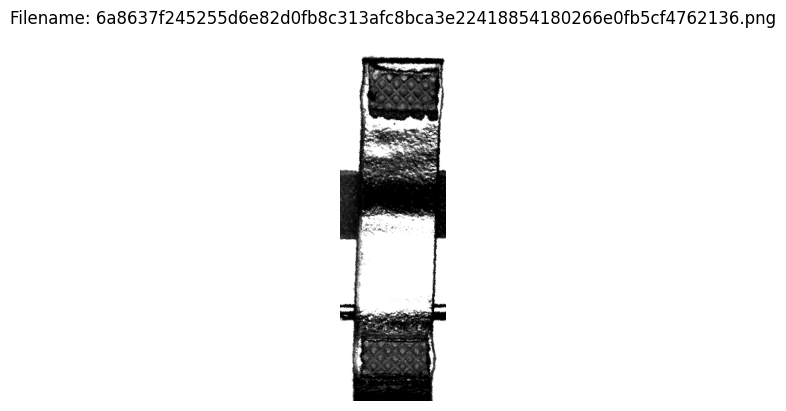

In [151]:
import pandas as pd
from PIL import Image
import os

import matplotlib.pyplot as plt

def show_image_from_csv(csv_file, image_folder, image_name):
    # Load the CSV file
    df = pd.read_csv(csv_file)
    
    # Find the row with the specified image name
    row = df[df['filename'] == image_name]
    
    if row.empty:
        print(f"No image found with name: {image_name}")
        return
    
    # Get the image path
    image_path = os.path.join(image_folder, image_name)
    
    # Open and display the image
    image = Image.open(image_path)
    plt.imshow(image, cmap='gray')
    plt.title(f"Filename: {image_name}")
    plt.axis('off')
    plt.show()

# Usage example
csv_file = 'with_probas_alamano.csv'
image_folder = '../input_test_rotcrop/'
image_name = '6a8637f245255d6e82d0fb8c313afc8bca3e22418854180266e0fb5cf4762136.png'
show_image_from_csv(csv_file, image_folder, image_name)

69: 6 to 3
67: 6 to 0 (pas sur)
74: 6 to 4
90: 6 to 0
93: 6 to 2
103: 6 to 0 (pas sur)
138: 6 to 0
150: 5 to 6
157: 0 to 6
171: 3 to 6
183: pas sur donc pas changé mais: 6 au lieu de 0 (?)
238: 6 to 4
244: 6 to 4
272: 6 to 0
287: 6 to 4
320: 0 to 6 (pas sur)
331: 2 to 0
340: 6 to 4
378: 6 to 0 (pas sur)
417: 6 to 2
435: 6 to 0
436: 6 to 0 --> même cas, trouver les bonnes classes dans le dataset 
445: 6 to 0 -->
463: 6 to 4
518: 6 to 0
523: 6 to 0 --> même cas
529: 6 to 2
549: 6 to 2
607: 3 to 6
619: 6 to  0 --> même cas
633: 6 to 0 --> même cas
638: 6 to 4
688: 6 to 4
694: 6 to 1
726: 2 to 6
745: 6 to 0 --> même cas



# **Grad Cam explainability**

In [15]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image


class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()
    
    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output
        
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]
        
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)
    
    def generate_cam(self, input_image, class_idx=None):
        self.model.eval()
        output = self.model(input_image)
        if class_idx is None:
            class_idx = output.argmax().item()
        
        self.model.zero_grad()
        output[:, class_idx].backward()
        
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]
        
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        
        for i, w in enumerate(weights):
            cam += w * activations[i]
        
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (input_image.shape[2], input_image.shape[3]))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

def preprocess_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(img_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image

def overlay_cam(image_path, cam, alpha=0.5):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(heatmap, alpha, image, 1 - alpha, 0)
    return superimposed_img

/home/emiliopicard/miniconda3/envs/valeo_env2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/emiliopicard/miniconda3/envs/valeo_env2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/emiliopicard/miniconda3/envs/valeo_env2/lib/python3.11/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Plea

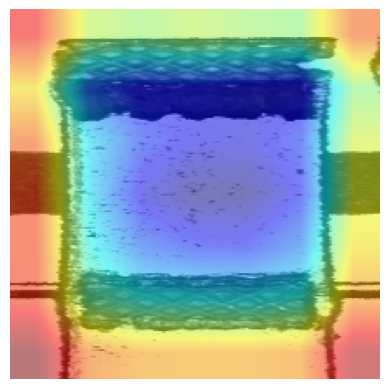

In [16]:
from model import Finetuned_Resnet101

model_state = torch.load("best_model_state_fc+layer4.pt", weights_only=False)
model = Finetuned_Resnet101()
model.load_state_dict(model_state)

target_layer = model.resnet.layer4[2].conv3
grad_cam = GradCAM(model, target_layer)
image_path = '../input_train_without_GOOD/9fcc8c0a175436c21745b7ce310face1e8bf0639c0845a4c08e0dd968b2adb0c.png'  # Change to your image path
input_image = preprocess_image(image_path)
cam = grad_cam.generate_cam(input_image)
heatmap_image = overlay_cam(image_path, cam)
plt.imshow(heatmap_image)
plt.axis('off')
plt.show()